In [2]:
import sys
sys.path.append('../utils')
sys.path.append('../core')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
from core import *

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob

In [3]:
test_phantom = phantom.Phantom(source_path = None,
            voxel_dims = (0.5e-3,0.5e-3,0.5e-3),
            matrix_dims = (100,100,100),
            baseline = (1500, 1000),
            seed = 5678,)

blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=5.3, scale=0.00001, label=1)
myocardium = tissue.Tissue(name='myocardium', c=1561.3, rho=1081, sigma=30, scale=0.0001, label=2)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=0, scale=1, label=3)

pos = 0.012

# test_phantom.add_tissue_sphere((pos,-pos,0), 2, blood)
# test_phantom.add_tissue_sphere((pos,0,0), 4, blood)
# test_phantom.add_tissue_sphere((pos,pos,0), 8, blood)

# test_phantom.add_tissue_sphere((-pos,-pos,0), 4, fat)
# test_phantom.add_tissue_sphere((-pos,0,0), 8, fat)
# test_phantom.add_tissue_sphere((-pos,pos,0), 2, fat)

# test_phantom.add_tissue_sphere((0,-pos,0), 8, myocardium)
# test_phantom.add_tissue_sphere((0,0,0), 2, myocardium)
# test_phantom.add_tissue_sphere((0,pos,0), 4, myocardium)

test_phantom.add_tissue(fat, mask=np.ones(test_phantom.matrix_dims))
test_phantom.add_tissue_sphere((pos,0,0), 4, myocardium)
test_phantom.set_default_tissue('fat')
test = test_phantom.get_complete()
# test_phantom.add_tissue_sphere((0,-pos,0), 4, myocardium)


(74, 50, 50)


257


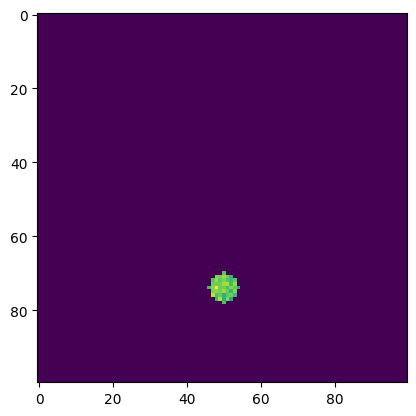

In [4]:
plt.imshow(test[0,:,:,test_phantom.matrix_dims[2]//2])
x = test_phantom.mask
print(np.sum(np.where(x != 3, 1, 0)))


In [5]:
transducers = [transducer.Planewave(max_frequency=1e6,
                                    elements = 32, 
                                    width = 20e-3,
                                    height =  10e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = 0,
                                    ray_num = 1, 
                                    imaging_ndims = 2,
                                    focus_elevation = 20e-3,
                                    ) for i in range(2)]

for t in transducers:
    t.make_sensor_coords(test_phantom.baseline[0])

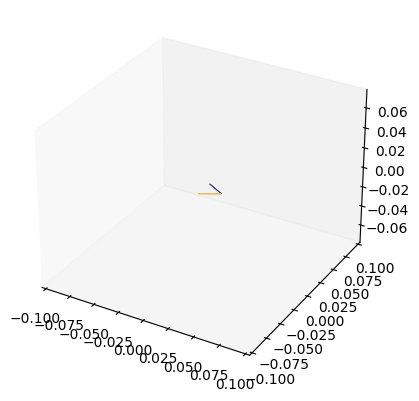

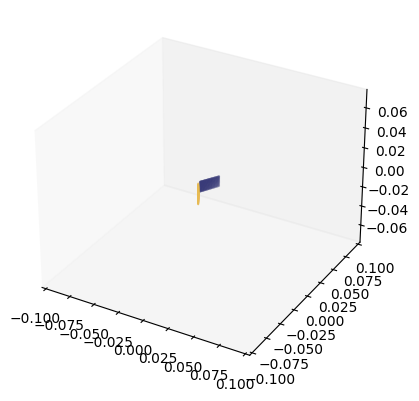

In [6]:
test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
#test_transducer_set.generate_extrinsics(shape="spherical", extrinsics_kwargs={'r_mean': 1e-3, 'view_std': 0, 'yaw_fraction': 1, 'pitch_fraction': 0, 'roll_fraction': 0})
test_transducer_set.assign_pose(0, geometry.Transform([-np.pi/6,0,0], [0,0.01,0]))
test_transducer_set.assign_pose(1, geometry.Transform([np.pi/6,0,0], [0,-0.01,0]))
test_transducer_set.plot_transducer_fovs(scale=0.1)
test_transducer_set.plot_transducer_coords(scale=0.1)

In [7]:
# test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='pressure_field')
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='extended_aperture')

In [8]:
print(test_sensor.sensor_coords.shape)
print(np.mean(test_sensor.sensor_coords[:test_sensor.sensor_coords.shape[0]//2, :], axis=0))
print(np.mean(test_sensor.sensor_coords[test_sensor.sensor_coords.shape[0]//2:, :], axis=0))


(832, 3)
[0.00000000e+00 9.99999978e-03 7.08901420e-20]
[ 0.00000000e+00 -9.99999978e-03  7.08901420e-20]


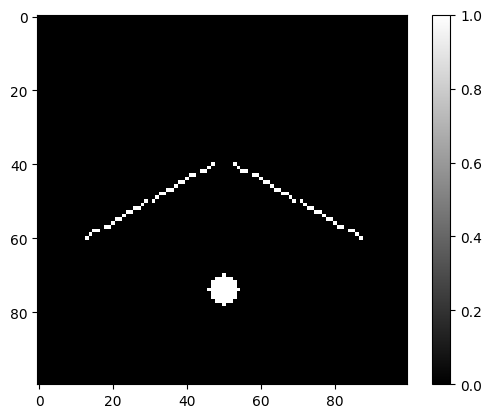

In [9]:
gm = test_sensor.visualize(test_phantom, test_phantom.matrix_dims[2]//2)

In [10]:
print(np.sum(gm) - 257)

832


In [11]:
simprops = simulation.SimProperties(
                grid_size   = (50e-3,50e-3,30e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [12]:
test_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/planewave_test_02',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 1,
                 additional_keys = ['p_max']
                 )

test_experiment.save()

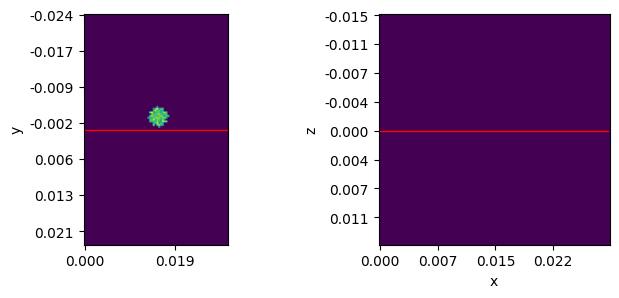

In [13]:
test_experiment.plot_ray_path(0)

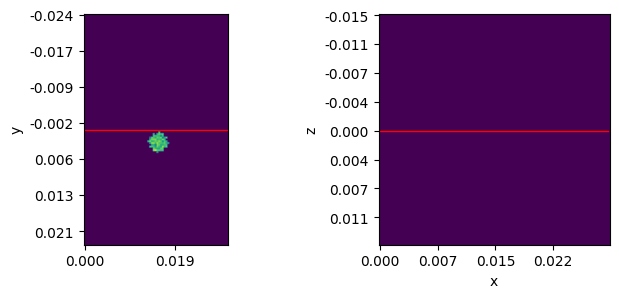

In [14]:
test_experiment.plot_ray_path(1)

In [15]:
test_experiment = experiment.Experiment.load('../experiment_files/planewave_test_02')
test_experiment.run(dry=True)

Number of simulation results (0) is less than the expected number of simulation results (2), are you sure the simulation finished running?
dry run of simulation


100%|██████████| 2/2 [00:00<00:00, 12.26it/s]

(832, 3)
442.0
(832, 3)
442.0
(832, 3)
442.0
(832, 3)
442.0
(832, 3)
442.0
(832, 3)
442.0


In [16]:
test_experiment.run(repeat=True)

running with 1 workers



Process prep:
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/aparnank/Documents/med_school/md_ra/software/musik/debugging/../core/experiment.py", line 234, in prep_worker
    if queue.qsize() > 3:
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/queues.py", line 126, in qsize
    return self._maxsize - self._sem._semlock._get_value()
NotImplementedError
Process run:
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 

In [17]:
# test_experiment.add_results()

In [18]:
# test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

In [19]:
# image = test_reconstruction.compound()

In [20]:
# image.shape

In [21]:
# test_reconstruction.results

In [22]:
# element_15 = np.array([test_reconstruction.results[i][1][15] for i in range(len(test_reconstruction.results))])
# element_0 = np.array([test_reconstruction.results[i][1][0] for i in range(len(test_reconstruction.results))])

In [23]:
# plt.plot(element_15.T)

In [24]:
# plt.plot(element_0.T)

In [25]:
# test_reconstruction.results[0]

In [26]:
# plt.imshow(image[:,:,image.shape[2]//2])
# plt.colorbar()

In [27]:
# plt.imshow(test_phantom.get_complete()[0,:,:,test_phantom.matrix_dims[2]//2])

In [28]:
# plt.imshow(image[image.shape[0]//2,:,:])
# plt.colorbar()

In [29]:
# plt.imshow(image[:,image.shape[1]//2,:])
# plt.colorbar()

In [30]:
# plt.imshow(test_phantom.get_complete()[0,:,:,test_phantom.matrix_dims[2]//2])

In [31]:
# im = test_reconstruction.results[0][1]

In [32]:
# im.shape

In [33]:
# for frame in tqdm.tqdm(range(0,im.shape[-1],10)):
#     plt.imshow(im[:,:,frame], cmap='bwr')
#     plt.colorbar()
#     plt.savefig(f'../experiment_files/outputs/frame_{str(frame).zfill(4)}.png', dpi=50)
#     plt.close()